# Process ch 1-4 with changing watertank shift
here I will process channel 1-4 with the changing watertank shift.
So the watertank value measurement time will fit to the DTS measurement time.
This will give some data gaps, because the Watertank temperature is not always avaible.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

import plotly
import plotly.express as px
import kaleido

# reloads modules if something is changed in them <-- thats real magic
# I can adapt my functions and dont have to restart the notebook to load the new stuff
# be carefull with dependencies, when using from ... import ...
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data, add_nan_val_in_datagaps, carpet_plot_with_gaps, save_values_in_file
from my_func_mvw.fourier_transform_func import resample_data_func, plot_frequency_spectrum, fourier_transform

plot_save=True #True False
show_large_plot=False #True False
save_data=True #True False; only data with segments is saved
fast_calc=False #True False; shortens the data, dont use it with save_data=True
process_without_segments=False #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #csv pickle #does not work for tlogger at the moment

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [52]:
# Load pickle Data
if importer == "pickle":
    data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# delete egrt cable channels
for egrt_chan in ["5","6","7","8"]:
    del data_all[egrt_chan]

In [53]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
string=["2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12", "14-07-2021 14:16:59", "22-07-2021 13:30:29"]
#string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00"] #same string as for ch 5-8
#string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "2021-08-02 11:08:00"] #adapted for ch 1-4; man könnte auch einfach alle weglassen
dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["1"].index[0] # first_date is before first string
last_date=data_all["4"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[0]] # first_date is before first string
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(0,len(dates[1:])): #skip first one because its first_segment
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)



In [54]:
#used for calculating segment wise mean
#for all segments before water tank logger measurements I need to use the first segment
calibration_segments_in_logger_range=calibration_segments[6:]
dates_in_logger_range = dates[5:]

## Raw data

every 10th value plotted


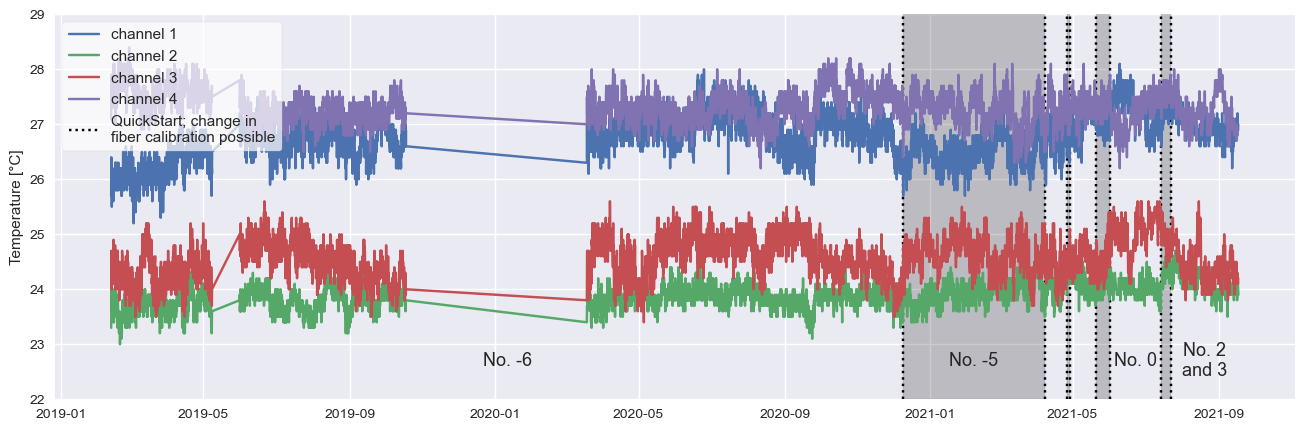

In [55]:
def plot_segments_overview(data, length=500, from_date=0, ymin=22,ymax=29,x=10, show_segments=True,plot_mean=False,resampled_data="no need if plot_mean=False"):
    """x: plot every x value"""
    # Correction Segments
    def color_cable_pos_seg(calibration_segment, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
        """ creates patches which color the plot
        I slightly adapt this for every notebook
        """
        start_len = calibration_segment[0].to_pydatetime()
        end_len = calibration_segment[1].to_pydatetime()
        width = end_len - start_len
        Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
        axs.add_patch(Rectangle)
        if label:
            #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
            bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
            date_num=(start_len+width/2)
            axs.text(date_num,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

    fig,axs=plt.subplots(1,1,figsize=(16,5))
    # plot QuickStart positions
    axs.vlines(dates,ymin,ymax,colors="black",linestyle=":",label="QuickStart; change in \nfiber calibration possible")

    # plot data
    for chan in ["1","2","3","4"]:
        val=round(data[chan][length][from_date:][::x],1) #nur jeder x Wert
        axs.plot(val.index.to_pydatetime(),val.values,label=f"channel {chan}")
    
    if plot_mean:
        # mean off all channels
        summe=0
        # to avoid datagaps when a nan occurs; I think I need calculate this date wise.
        for chan in ["1","2","3","4"]:
            summe += resampled_data[chan][length]
        mean=summe/4 #nan values should cause nan in mean too
        mean=mean[::x]
        axs.plot(mean.index.to_pydatetime(),mean.values,label=f"mean of all channels",color="black", linestyle="--")
        axs.fill_between(mean.index.to_pydatetime(),mean.values-1, mean.values+1,
                        #facecolor="blue", # The fill color
                        color='#7fc7ff',       # The outline color
                        alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

    if show_segments:
        # Color plot
        # Ich muss anscheinend hier axs explicit einfügen
        alph=0.0
        counter=-6
        for segment in calibration_segments:
            if counter in [-6,-5,0,2]: #No.2 and No.3 are one segment here
                if_label=True
            else:
                if_label=False
            if counter==2:
                counter_print="2\nand 3"
            else:
                counter_print=counter
            color_cable_pos_seg(segment,alph,ymax=ymax,ymin=ymin,axs=axs, label_name=f"No. {counter_print}",label=if_label)
            if alph == 0.0:
                alph+=0.2
            elif alph == 0.2:
                alph=0.0
            if counter==2:
                counter+=2
            else:
                counter+=1

    #axs.set_xlabel("Date")
    axs.set_ylabel("Temperature [°C]")
    axs.set_ylim(ymin,ymax)
    legend = plt.legend(fontsize=11, title_fontsize=11,frameon=True,loc="upper left")
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    print(f"every {x}th value plotted")

    return length

# Plot raw data
length=plot_segments_overview(data_all)
# Save additional information so I can read them in my tex file
save_values_in_file(1,"cable_length_plot_raw_data_ch14",length,r"..\Masterthesis_tex\values_for_read_in_tex.txt")

if plot_save:
    plt.savefig(r"pictures\raw_data_ch14.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\raw_data_ch14.pdf", format="pdf",bbox_inches="tight")
plt.show()

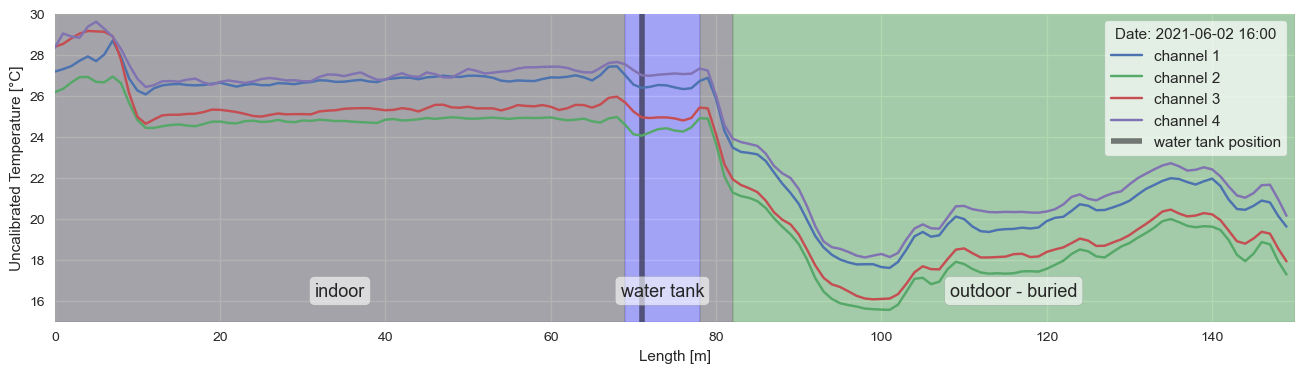

In [56]:
def color_cable_pos(start_len, end_len, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.6)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

iloc_date_index=59812
ymin=15;ymax=30
fig,axs=plt.subplots(1,1,figsize=(16,4))
for chan in ["1","2","3","4"]:
    data_chan=data_all[chan].iloc[iloc_date_index][:150]
    axs.plot(data_chan,label=f"channel {chan}")

date_name=str(data_all["2"].iloc[iloc_date_index].name.round("1h"))[:-3]
axs.set_ylabel("Uncalibrated Temperature [°C]")
axs.set_xlabel("Length [m]")
axs.set_xlim(0,150)
axs.set_ylim(ymin,ymax)
axs.vlines([71],ymin,ymax,label="water tank position",color="black",linewidth=4,alpha=0.5)

color_cable_pos(0,69,0.3,ymax=ymax,ymin=ymin,axs=axs, label_name="indoor", label=True)
color_cable_pos(69,78,0.3,ymax=ymax,ymin=ymin,axs=axs,col="blue", label_name="water tank", label=True)
color_cable_pos(78,82,0.3,ymax=ymax,ymin=ymin,axs=axs,col="black")
color_cable_pos(82,150,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor - buried", label=True)

legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True,title=f"Date: {date_name}",loc="upper right")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\appendix\watertank_loc_raw_ch14.pdf", format="pdf",bbox_inches="tight")
    plt.savefig("pictures\watertank_loc_raw_ch14.png")
plt.show()

In [57]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-09-17 12:04:53,20.3,NaN,20.3
2021-09-17 12:07:53,20.3,NaN,20.3
2021-09-17 12:10:54,20.3,NaN,20.3
2021-09-17 12:13:54,20.3,NaN,20.3


## Aligning

In [58]:
# 60s
data_all_processed=deepcopy(data_all)
a = data_all_processed
#delete some dates so all gaps are alligned

# allign first dates
a["1"] = a["1"].drop(a["1"].index[0],axis=0)

a["1"] = a["1"].drop(a["1"].index[274],axis=0)
a["2"] = a["2"].drop(a["2"].index[274],axis=0)
a["3"] = a["3"].drop(a["3"].index[274],axis=0)

a["1"] = a["1"].drop(a["1"].index[4263],axis=0)
a["2"] = a["2"].drop(a["2"].index[4263],axis=0)
a["4"] = a["4"].drop(a["4"].index[4263],axis=0)

a["1"] = a["1"].drop(a["1"].index[12485],axis=0)

a["1"] = a["1"].drop(a["1"].index[20211],axis=0)
a["2"] = a["2"].drop(a["2"].index[20211],axis=0)
a["3"] = a["3"].drop(a["3"].index[20211],axis=0)

# only measurements from 29.01.2020 are droped here, because they are not alligned
a["1"] = a["1"].drop(a["1"].index[20215 : 20217],axis=0)
a["2"] = a["2"].drop(a["2"].index[20215 : 20217],axis=0)
a["3"] = a["3"].drop(a["3"].index[20215 : 20218],axis=0)
a["4"] = a["4"].drop(a["4"].index[20215],axis=0)

a["1"] = a["1"].drop(a["1"].index[20217],axis=0)

a["1"] = a["1"].drop(a["1"].index[21171],axis=0)
a["2"] = a["2"].drop(a["2"].index[21171],axis=0)
a["3"] = a["3"].drop(a["3"].index[21171:21173],axis=0)
a["4"] = a["4"].drop(a["4"].index[21171],axis=0)

a["1"] = a["1"].drop(a["1"].index[40532],axis=0)
a["2"] = a["2"].drop(a["2"].index[40532],axis=0)
a["3"] = a["3"].drop(a["3"].index[40532],axis=0)
a["4"] = a["4"].drop(a["4"].index[40532],axis=0)

a["1"] = a["1"].drop(a["1"].index[44126],axis=0)
a["2"] = a["2"].drop(a["2"].index[44126],axis=0)
a["3"] = a["3"].drop(a["3"].index[44126],axis=0)
a["4"] = a["4"].drop(a["4"].index[44126],axis=0)

a["1"] = a["1"].drop(a["1"].index[53895],axis=0)

a["1"] = a["1"].drop(a["1"].index[54822],axis=0)

a["1"] = a["1"].drop(a["1"].index[56698],axis=0)
a["2"] = a["2"].drop(a["2"].index[56698],axis=0)

a["1"] = a["1"].drop(a["1"].index[56700],axis=0)

a["1"] = a["1"].drop(a["1"].index[58407],axis=0)
a["2"] = a["2"].drop(a["2"].index[58407],axis=0)

a["1"] = a["1"].drop(a["1"].index[58678:58681],axis=0)
a["2"] = a["2"].drop(a["2"].index[58678:58682],axis=0)
a["3"] = a["3"].drop(a["3"].index[58678:58680],axis=0)
a["4"] = a["4"].drop(a["4"].index[58678:58680],axis=0)

a["1"] = a["1"].drop(a["1"].index[59747],axis=0)

a["1"] = a["1"].drop(a["1"].index[62154],axis=0)
a["2"] = a["2"].drop(a["2"].index[62154],axis=0)
a["3"] = a["3"].drop(a["3"].index[62154],axis=0)

# do not change order of these, because this would change the indexes for the others
a["1"] = a["1"].drop(a["1"].index[20216],axis=0)
a["2"] = a["2"].drop(a["2"].index[20216],axis=0)
a["3"] = a["3"].drop(a["3"].index[20216],axis=0)
a["4"] = a["4"].drop(a["4"].index[20216],axis=0)


############needs to be adapted with every new import##################
a["1"] = a["1"].drop(a["1"].index[-1],axis=0)
a["2"] = a["2"].drop(a["2"].index[-1],axis=0)
#########################################################################

In [59]:
data_all_processed_withoutTlogger = deepcopy(data_all_processed)
data_all_processed = cut_dataframe_to_range_tlogger(channels=["1","2","3","4"],data=data_all_processed,watertank_T_range_min=watertank_T_range_min, watertank_T_range_max=watertank_T_range_max, do_check=False)

In [60]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_withoutTlogger,["1","2","3","4"],title_prefix="Raw temperature ",
                         vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\raw_data_ch14_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\raw_data_ch14_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()

In [61]:
# Check my processed data
print("Check data_all_processed:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed)

print()
print("Check data_all_processed_withoutTlogger:")
my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed_withoutTlogger)

Check data_all_processed:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed

Check data_all_processed_withoutTlogger:
Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [62]:
if fast_calc:
    for chan in data_all_processed_withoutTlogger.keys(): #only use every 10s value at the moment to make calcukations faster
        data_all_processed_withoutTlogger[chan] = data_all_processed_withoutTlogger[chan][::10]

## Calculate offset and shift

In [63]:
# 60s
watertank_len=[71] # position DTS cable, where it is in watertank
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger_PT100, channels=["1","2","3","4"], watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Performance warning ist denke ich nicht so wichtig

### Process ch 1-4 with mean watertank shift
here I will process channel 1-4 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.
##### Plot: Is shift time dependent

In [64]:
if process_without_segments:
    calibration_nosegments_mean_correction_real_data={}
    for chan in ["1","2","3","4"]:
        calibration_nosegments_mean_correction_real_data[chan]=np.nanmean(watertank_diff_log_data_all[chan].loc[watertank_len[0]])

if process_without_segments == False:
    result = calc_mean_for_each_segment(["1","2","3","4"], calibration_segments_in_logger_range, watertank_diff_log_data_all, watertank_len)
    calibration_segments_mean_correction_real_data = result[0]
    # only for finding correspnfing values in watertank_diff_log_data_all; not in data_all !!!
    calibration_segments_mean_correction_real_data_dates = result[1] 
    del result

In [65]:
calibration_segments_mean_correction_real_data

{'1': [2.8562093862815887, 2.8051315789473685, 2.6705860805860806],
 '2': [-0.06502890173410392, 0.16258771929824603, 0.06535612535612546],
 '3': [0.8965437454808388, 0.5408333333333338, 0.2307369706840392],
 '4': [3.1516052060737527, 3.5408733624454154, 3.096482084690554]}

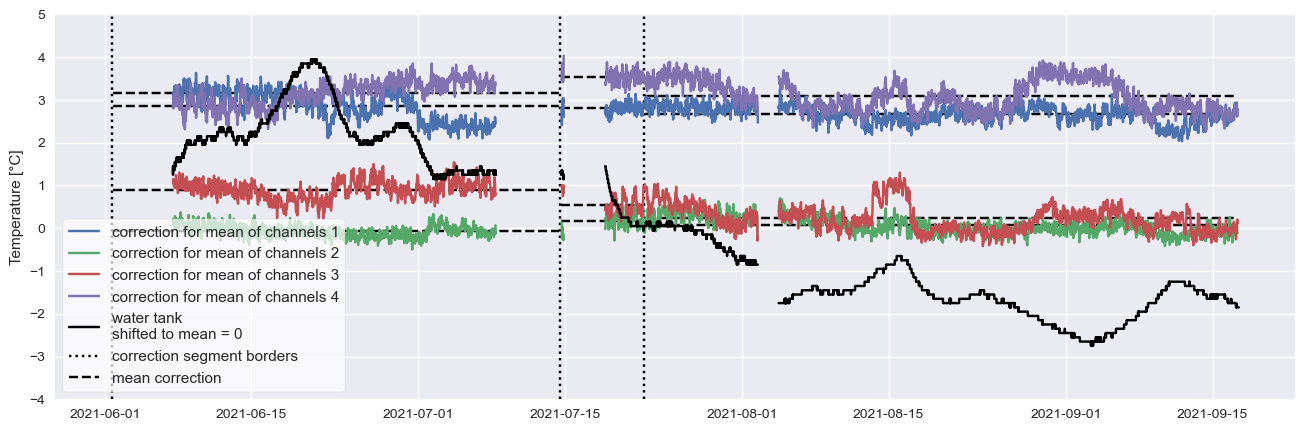

In [66]:
if process_without_segments == False:
    plot_segments_mean_correction(calibration_segments_mean_correction_real_data,dates_in_logger_range,calibration_segments_mean_correction_real_data_dates,
        watertank_diff_log_data_all,df_Tlogger_PT100,watertank_len,ymax=5, ymin=-4)


    if plot_save:
        plt.savefig(r"pictures\analyse_watertank_correction_ch14.png",bbox_inches="tight")
        plt.savefig(r"..\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch14.pdf", format="pdf",bbox_inches="tight")

    plt.show()

In [67]:
if process_without_segments:
    ymax=5; ymin=-4
    start = pd.to_datetime("2021-06-01 19:00:00")
    end=watertank_diff_log_data_all["1"].columns[-1]
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    for chan in ["1","2","3","4"]:
        x=watertank_diff_log_data_all[chan].columns
        y=watertank_diff_log_data_all[chan].loc[watertank_len[0]]
        axs.plot(x,y,label=f"correction for channel {chan}")

        axs.hlines(calibration_nosegments_mean_correction_real_data[chan], start, end, color="black", linestyle="--", label="mean correction")

    # plot watertank Temp for comparisson
    name="Channel1-PT100_rolling_mean"
    mean = np.nanmean(df_Tlogger_PT100[name].values)
    y=df_Tlogger_PT100[name].values - mean
    x_dates=df_Tlogger_PT100[name].index
    axs.plot(x_dates,y,color="black", label="water tank\nshifted to mean = 0")

    axs.set_title("Analyse Water Tank Correction", fontsize=13)
    axs.set_xlabel("Date")
    axs.set_ylabel("Temperature [°C]")
    axs.set_ylim(ymin,ymax)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # but them in dictionary: uniqueness, multiple labels are dropped
    # make legend looking nicer
    legend = axs.legend(by_label.values(), by_label.keys(),fontsize=11, title_fontsize=12,frameon=True) #loc="upper right"
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_alpha(0.7)


    if plot_save:
        plt.savefig(r"pictures\analyse_watertank_correction_ch14_nosegments.png",bbox_inches="tight")
        plt.savefig(r"..\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch14_nosegments.pdf", format="pdf",bbox_inches="tight")

    plt.show()

In [68]:
if process_without_segments==False:
    # add shift value for segments, which can be calibrated from real data (segments before first water tank measurements)
    calibration_segments_mean_correction_all_segments = {}
    n_segments = 6 # number of segments before the first segment with real data
    for chan in calibration_segments_mean_correction_real_data.keys():
        real_val_chan = calibration_segments_mean_correction_real_data[chan] #the segment correction values from the segments with real data
        all_segments_val_chan=[]
        for i in range(n_segments):
            all_segments_val_chan.append(real_val_chan[0]) # use first segment with real data for all segments before
        
        for i in range(len(real_val_chan)):
            all_segments_val_chan.append(real_val_chan[i]) # add segments with real data to new list
        
        calibration_segments_mean_correction_all_segments[chan] = all_segments_val_chan

In [69]:
# px.imshow(round(data_all["2"][::10],1),zmin=20,zmax=30)

### Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the atertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [70]:
# only used every 10s value in processing the data if using fast_calc
if process_without_segments==False:
    data_all_processed_constshifted = const_shift_data(["1","2","3","4"], calibration_segments, calibration_segments_mean_correction_all_segments, data_all_processed_withoutTlogger,round_x=2)
    if save_data:
        write_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted",data_all_processed_constshifted)

        copy_file(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted", path_to_my_database + "\data_ch1-4_processed_constshifted")

if process_without_segments:
    data_all_processed_constshifted={}
    # Correct data
    for chan in ["1","2","3","4"]:
        mean_correction = calibration_nosegments_mean_correction_real_data[chan]
        data_all_processed_constshifted[chan] = data_all_processed_withoutTlogger[chan] - mean_correction

In [71]:
# sollten das resamplete nochmal überprüfen!!!!!!!!!!!!!!!
# Used later in plot
resampled_data={}
sample_hours=1 #need to play arounf with it until all chanells have same index length after resample
for chan in ["1","2","3","4"]:
    # skip first row so all dataframes start at 14:xx:xx --> resampled to same dates
    # skip last so all end at same hour; NEEDS TO BE ADAPTED WITH NEW DATA
    data_with_nan = add_nan_val_in_datagaps(data_all_processed_constshifted[chan][1:-1], minutes_gap=35)
    resampled_data[chan]=data_with_nan.resample(f"{sample_hours}H").ffill()

print("Index Length:")
for chan in ["1","2","3","4"]:
    print(f"{chan}: {len(resampled_data[chan].index)}")
    print(f"first date: {resampled_data[chan].index[0]}; last date: {resampled_data[chan].index[-1]}")
    
# original data
#print("Index Length:")
#for chan in ["5","6","7","8"]:
#    print(f"{chan}: {len(data_all_processed_constshifted[chan].index)}")
#    print(f"first date: {data_all_processed_constshifted[chan].index[1]};
#          last date: first date: {data_all_processed_constshifted[chan].index[-1]}")

7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added
Index Length:
1: 22752
first date: 2019-02-12 10:00:00; last date: 2021-09-17 09:00:00
2: 22752
first date: 2019-02-12 10:00:00; last date: 2021-09-17 09:00:00
3: 22752
first date: 2019-02-12 10:00:00; last date: 2021-09-17 09:00:00
4: 22752
first date: 2019-02-12 10:00:00; last date: 2021-09-17 09:00:00


every 10th value plotted


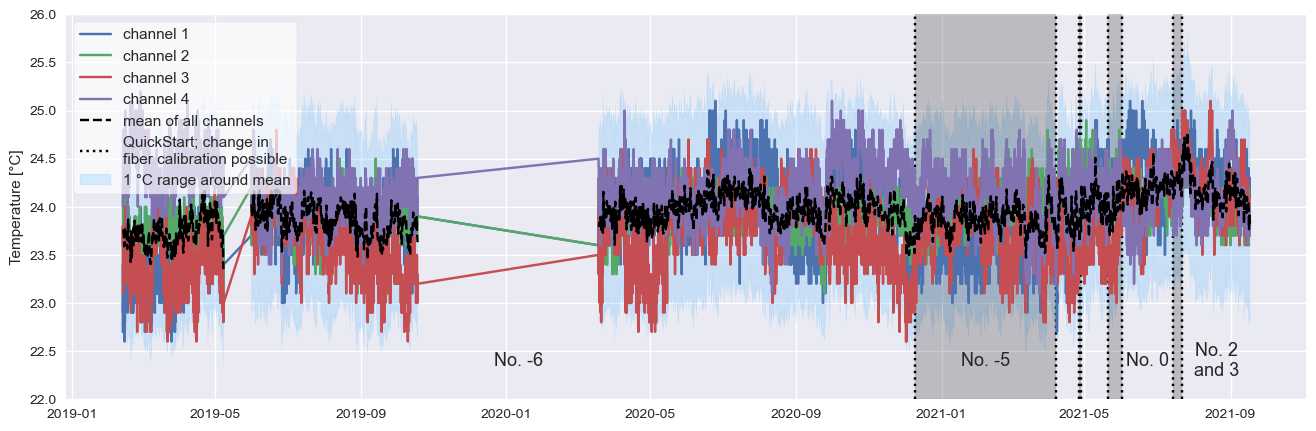

In [72]:
# Plot shifted data
show_segments=True
if process_without_segments:
    show_segments=False

cable_length=plot_segments_overview(data_all_processed_constshifted, length=500, from_date=0, ymin=22,ymax=26,x=10,show_segments=show_segments,plot_mean=True,resampled_data=resampled_data)

# Save additional information so I can read them in my tex file
save_values_in_file(2,"cable_length_plot_final_data_ch14_one_length",cable_length,r"..\Masterthesis_tex\values_for_read_in_tex.txt")

if process_without_segments==False:
    if plot_save:
        plt.savefig(r"..\Masterthesis_tex\figs\chap4\final_data_ch14_one_length.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r".\pictures\final_data_ch14_one_length.png",bbox_inches="tight")
if process_without_segments:
    if plot_save:
        plt.savefig(r"..\Masterthesis_tex\figs\chap4\final_data_ch14_one_length_nosegments.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r".\pictures\final_data_ch14_one_length_nosegments.png",bbox_inches="tight")
plt.show()

# wenn ich beim letzten Segment mehr Daten habe passt es evntl besser? Oder ich muss erstes Segment noch um 0.1 mehr verschieben?
# Vergleich zwischen channel 7 und 8 für zweites segment sehr komische
# es könnte auch sein, dass channel 8 bemessen wurde als die Heizphase gerade aus gemacht wurde
# Für diesen Test sind kurze Messzeiten auf Kosten der Genauigkeit besser, da sich Temperatur ja schnell ändert
# erklärt es aber eigentlich nicht wirklich, müsste dann trotzdem viel ähnlicher sein
# es sieht so aus als ob channel 8 in segment 2 noch Manuel etwas nach unten verschoben werden sollte
# letztes Segment in channel 7 manuel nach oben verschieben?

# Extract Shaft

In [73]:
begin_shaft=200 # muss ich noch genauer nachgucken +- 2 m vielleicht
# muss auch noch genauer überprüft werden, dieser Wert beschreibt wie weit die Faser von Channel 1 und 3 geht, bevor sie wieder nach oben geht
complete_shaft_length = 860
shaft={}
for chan in ["1","2","3","4"]:
    if chan in ["2","4"]: #shorter channels
        col = data_all_processed_constshifted[chan].columns[begin_shaft:]
    if chan in ["1","3"]: #longer channels
        col = data_all_processed_constshifted[chan].columns[begin_shaft:begin_shaft + complete_shaft_length]
    shaft[chan] = data_all_processed_constshifted[chan][col]
    shaft[chan].columns = np.arange(0,shaft[chan].columns.max() + 1 - begin_shaft)
    shaft[chan].columns.names=["Depth [m]"]
    shaft[chan] = round(shaft[chan],1)


In [74]:
# Save final Temperature Shaft
if save_data:
    save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\old_cable\pickle"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        write_pickle(save_to+filename,shaft[chan])

    save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\old_cable\csv"
    for chan in ["1","2","3","4"]:
        filename=f"\\Schacht_chan_{chan}"
        shaft[chan].to_csv(save_to+filename+".csv")

In [75]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_constshifted,["1","2","3","4"],title_prefix="Final temperature ",
                          vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\final_data_ch14_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\final_data_ch14_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()

# Frequency analysis

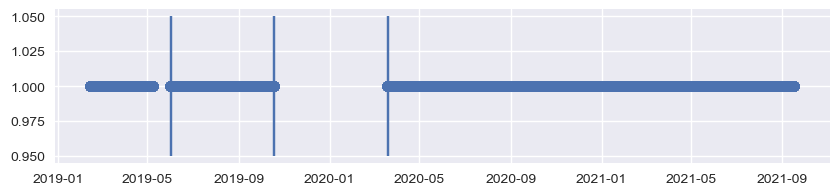

In [76]:
#visualize data gaps
data=data_all_processed_constshifted["1"][cable_length].index
plt.figure(figsize=(10,2))
plt.scatter(data.to_pydatetime(), np.ones(len(data)))
plt.vlines([data[20300],data[20200],data[7800]],0.95,1.05)
plt.show()

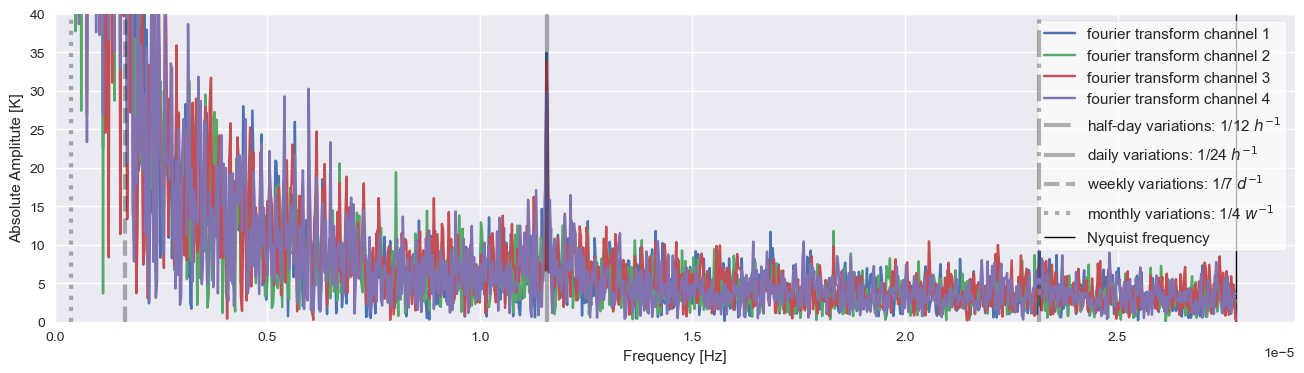

In [77]:
## Frequency spectrum data
data_resample={}
sampling_time={}
yf={}
xf={}
#depth=150
cable_length=71 #only for data_all_processed_constshifted
data_type="data_all" # I create a plot with this data type for my thesis
ylim=[0,40]
for channel in ["1","2","3","4"]:
    #for cable_length in [65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]:
    # looks good, I could also average multiple length for watertank correction

    # im wassertank höhere daily variation als außerhalb, wo es im Boden ist
    # mehr als bei channels 5 to 8
    # warum? Ideen: Kabel dünner, liegt im Wassertank anders
    # Vor Wassertank, im Gebäude daily variation noch viel höher

    # 27500: only dates where tlogger was active
    # 20300: dates after large datagap
    # 7800:20200 dates before large data gap
    #removed large timegap 
    #data=data_all_processed_constshifted[channel][cable_length][20300:]
    #data=data_all_processed_constshifted[channel][cable_length][7800:20200]
    #data=shaft[channel][depth][20300:]

    if data_type == "data_all":
        data=data_all[channel][cable_length][31000:] #raw data

    # Resample data
    data_resample[channel], sampling_time[channel], nyquist_frequency = resample_data_func(data)

    # Fourier Transform
    yf[channel], xf[channel] = fourier_transform(data_resample[channel], sampling_time[channel])

# Plor fourier Spectrum
vlines=[] #[0.8e-6], [2e-6]
vlines_labels=[] #"filter border, about 1/14 days","filter border, about 1/6 days"
#print(f"channel {channel}; cable length or depth: {data.name} m")
plot_frequency_spectrum(xf, yf, vlines, vlines_labels,nyquist_frequency, ylim=ylim)

if cable_length == 71 and data_type=="data_all" and ylim==[0,40]:
    if plot_save:
        plt.savefig(r"..\Masterthesis_tex\figs\chap4\chan14_cable_length_71_fourier.pdf", format="pdf",bbox_inches="tight")
        plt.savefig("pictures\chan14_cable_length_71_fourier.png")
plt.show()


# Amplitude sagt hier ja nicht den Einfluss auf die Daten aus oder?
# tägliche Variationen von 35 K werden durch andere teilweise ausgeglichen?


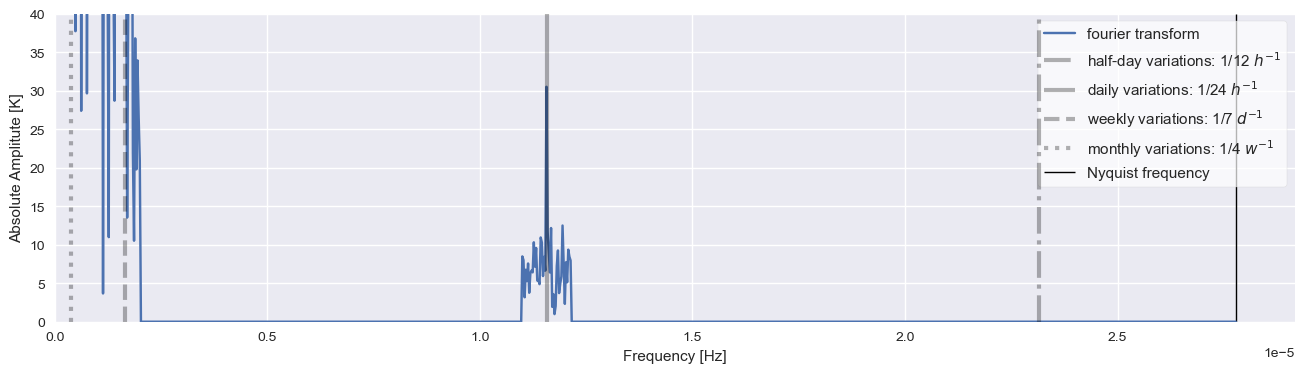

In [78]:
#Signal Filtering - specific filter functions exists, which minimise artefacts
channel="2"
f_signal = yf[channel]
W = xf[channel]
# 1 day fluctutation:
T_day=24*60*60
f_day=1/T_day

# remove frequencies from signal
cut_f_signal = f_signal.copy()
cut_f_signal[(W>1.05*f_day)] = 0
cut_f_signal[((W<0.95*f_day) & (W>2e-6))] = 0
#cut_f_signal[(W>0.8e-6)] = 0

plot_frequency_spectrum(W, cut_f_signal, vlines, vlines_labels,nyquist_frequency, ylim=[0,40])
plt.show()

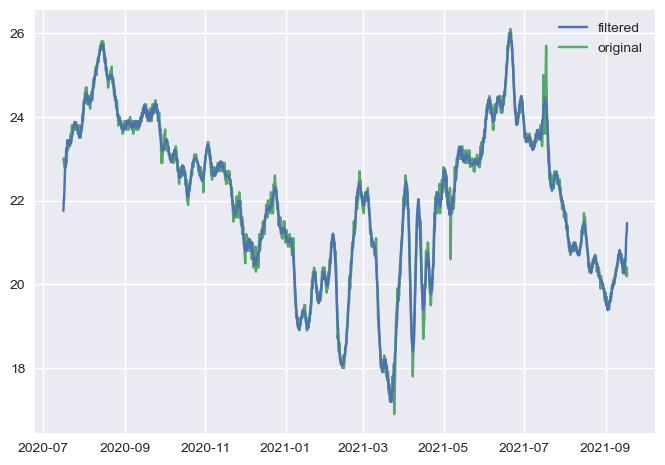

In [79]:
# Retransfrom
cut_signal = irfft(cut_f_signal)

# Plot filtered signal
dates=5000000000 #only show last x days
plt.plot(data_resample[channel].index[-dates:].to_pydatetime(),cut_signal[-dates:],label="filtered",zorder=10) #depending on channel add [1:]
plt.plot(data_resample[channel].index[-dates:].to_pydatetime(),data_resample[channel].values[-dates:],label="original",zorder=1)
plt.legend()
plt.show()

# force filtered signal to show dayly variations
# Are these real, or device dependent?